<a href="https://colab.research.google.com/github/fraxinus1098/socialmediaanalytics/blob/main/HW5_ABTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 - A/B Testing

This notebook provides some skeleton code to get you started on the homework. Add in your own code and markdown cells to answer the homework questions. If you want to submit the notebook as a PDF, make sure your code and markdowns are clear and concise to make grading easy for the TAs.
This notebook can be opened in Colab Open In Colab

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab. This will save the notebook in your Google Drive.





# Clones, Installs, and Imports

## Clone GitHub Repository
This will clone the repository to your machine. This includes the code and data files. Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 2690, done.
remote: Counting objects: 100% (2690/2690), done.
remote: Compressing objects: 100% (2268/2268), done.
remote: Total 2690 (delta 452), reused 2654 (delta 417), pack-reused 0
Receiving objects: 100% (2690/2690), 175.00 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (452/452), done.
Updating files: 100% (1965/1965), done.


## Install Packages

In [ ]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests


#display settings for figures
pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'axes.labelsize': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
plt.rcParams['figure.figsize'] = [8, 6]
###

import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from transformers import RobertaTokenizer, RobertaModel
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import sklearn.cluster as cluster
from sklearn import metrics
from scipy import stats

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



import scripts.TextAnalysis as ta

#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
###

#Instagram analysis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from PIL import Image as PILImage
from matplotlib.patches import Ellipse

#Image processing with Resnet
import torch
from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler

#Low dimensional embedding algorithms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

#Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Import Packages

In [ ]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.7 MB/s eta 0:00:00


# Problem 1. (30 points) Tweet Sentiment

## 1. (2 points) Load data

Load the tweets in the file `"data/oreo_sentiment.csv"` into a dataframe. Print out the head of this dataframe so we know you did it right.

In [ ]:
fname = "data/oreo_sentiment.csv"

df = pd.read_csv(fname)
ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.screen_name.unique()
df.head()

dataframe has 3000 tweets


,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,sentiment
0,0,2022-01-28T22:03:44.000Z,Oreo,"@_JuiceJones What happened there? Let's fix this. Could you send us a DM with the package's UPC and expiration date, incl. the numbers/letters that follow? https://t.co/2mOFfNnQW0",en,1,0,1,0,1487184644600737794,126084292,1486849965955727364,8.274650e+07,None,2.102369
1,1,2022-01-28T21:36:06.000Z,Oreo,@ZeqoeR6 That's the best we have. 🤔,en,0,2,6,0,1487177690226597893,126084292,1486831768846188550,2.860886e+09,None,4.848118
2,2,2022-01-28T21:08:25.000Z,Oreo,@gagadaily the day all of our lives changed! truly iconic. https://t.co/zbJM37xbty,en,16,5,277,1,1487170722166452224,126084292,1487135476972761094,2.437448e+07,None,4.775955
3,3,2022-01-28T20:31:27.000Z,Oreo,@mswizzle44 They're available nationwide! We recommend checking larger retailers like Walmart in your area 🤞,en,0,2,1,0,1487161422895366146,126084292,1486714137996529666,4.646480e+09,None,4.485816
4,4,2022-01-28T19:25:47.000Z,Oreo,"@YaBoyShizo We'd like to get to the bottom of this! Could you send us a DM with the package's UPC and expiration date, incl. the numbers/letters that follow? https://t.co/2mOFfNnQW0",en,0,0,0,0,1487144893436895246,126084292,1486534320894455810,2.333453e+08,None,2.268613


## 2. (10 points) Cluster tweets

Clean the text with the `clean_tweet` function and calculate the tf embedding.  Then calculate the two dimensional UMAP embedding of this embedding.  Finally, use k-means to cluster the UMAP embeddings into `k=4` clusters.  Make a count plot of the number of tweets in each cluster and a bar plot of the mean sentiment per cluster, with proper axis labels and title.  This question might look familiar to you (check a previous homework).

In [ ]:
#Clean_tweet
df['text_clean'] = df['text'].apply(ta.clean_tweet)  #clean the tweets
df = df[df['text_clean'].str.len() >0]  #remove cleaned tweets of lenght 0

In [ ]:
#Calculate the tf embedding
tf_vectorizer = CountVectorizer(min_df=5, stop_words='english')
tf_embedding = tf_vectorizer.fit_transform(df['text_clean'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

nvocab = len(tf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")
print(f"TF embedding shape is {tf_embedding.shape}")

2995 tweets, 516 words in vocabulary
TF embedding shape is (2995, 516)


In [ ]:
# prompt: Calculate the two dimensional UMAP embedding of this embedding

umap_embedding = UMAP(n_components=2, min_dist=0.0, metric='cosine').fit_transform(tf_embedding.toarray())


In [ ]:
# prompt: use k-means to cluster the UMAP embeddings into k=4 clusters

kmeans = cluster.KMeans(n_clusters=4, random_state=0).fit(umap_embedding)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


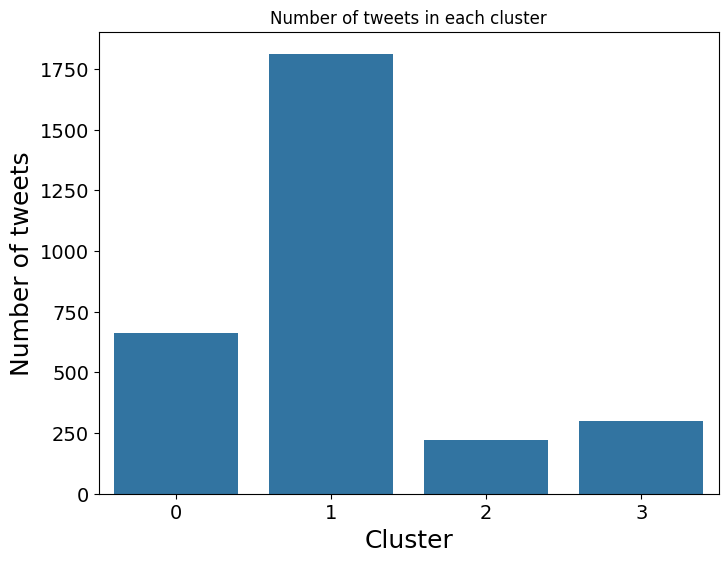

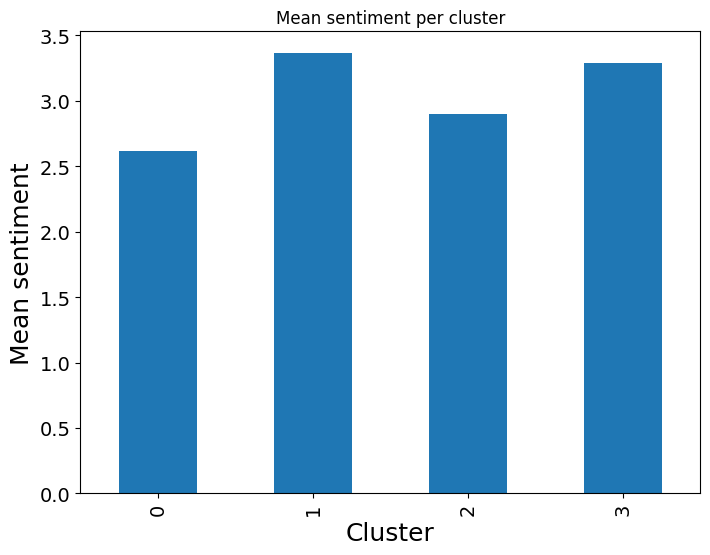

In [ ]:
# prompt: Make a count plot of the number of tweets in each cluster and a bar plot of the mean sentiment per cluster, with proper axis labels and title

import matplotlib.pyplot as plt
# Count plot of the number of tweets in each cluster
sns.countplot(x=kmeans.labels_, data=df)
plt.xlabel('Cluster')
plt.ylabel('Number of tweets')
plt.title('Number of tweets in each cluster')
plt.show()

# Bar plot of the mean sentiment per cluster
mean_sentiment = df.groupby(kmeans.labels_)['sentiment'].mean()
mean_sentiment.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment per cluster')
plt.show()


## 3. (4 points) Plot mean sentiment vs mean retweet count per cluster

Make a scatterplot of the mean sentiment  vs the mean retweet count of each k-means cluster.  Set the marker size to 1000.   Make sure to add axes labels and a title to the figure.  

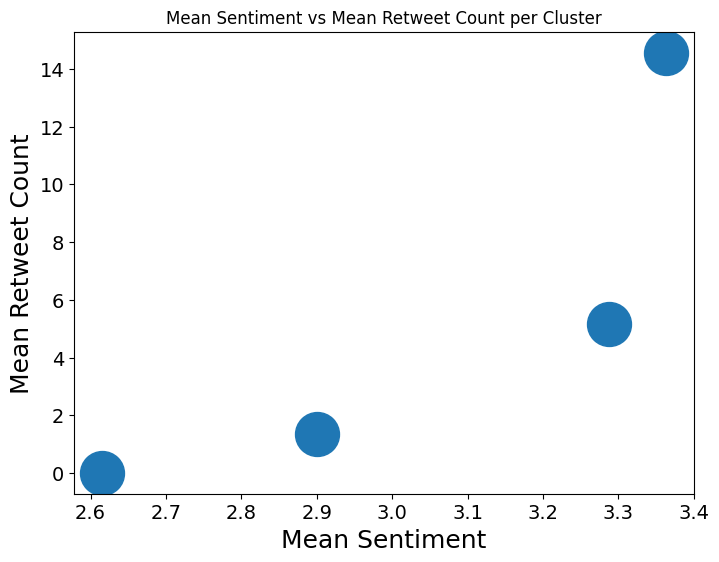

In [ ]:
# prompt: Make a scatterplot of the mean sentiment vs the mean retweet count of each k-means cluster. Set the marker size to 1000. Make sure to add axes labels and a title to the figure.

import matplotlib.pyplot as plt
# Calculate the mean sentiment and mean retweet count for each cluster
mean_sentiment = df.groupby(kmeans.labels_)['sentiment'].mean()
mean_retweets = df.groupby(kmeans.labels_)['retweet_count'].mean()

# Create a scatterplot of mean sentiment vs mean retweet count
plt.scatter(mean_sentiment, mean_retweets, s=1000)
plt.xlabel('Mean Sentiment')
plt.ylabel('Mean Retweet Count')
plt.title('Mean Sentiment vs Mean Retweet Count per Cluster')
plt.show()


## 4. (4 points) Correlation of retweet count and sentiment

Calculate the Pearson correlation coefficient of the mean sentiment and mean retweet count of the clusters.  Print the coefficient and p-value up to three decimal points.  Is the correlation significant at a 1% level?

In [ ]:
# prompt: Calculate the Pearson correlation coefficient of the mean sentiment and mean retweet count of the clusters. Print the coefficient and p-value up to three decimal points. Is the correlation significant at a 1% level?

# Calculate the Pearson correlation coefficient
corr, pval = stats.pearsonr(mean_sentiment, mean_retweets)

# Print the coefficient and p-value
print(f"Pearson correlation coefficient: {corr:.3f}")
print(f"p-value: {pval:.3f}")

# Is the correlation significant at a 1% level?
if pval < 0.01:
    print("The correlation is significant at a 1% level.")
else:
    print("The correlation is not significant at a 1% level.")


Pearson correlation coefficient: 0.837
p-value: 0.163
The correlation is not significant at a 1% level.


## 5. (10 points) T-test of cluster sentiment

Find the clusters with the lowest and highest mean sentiment and print their cluster label so we know who you are checking.  Then use a t-test to determine if these mean sentiments are different at a 1% level.  Print your t-statistics, pvalues, and whether it is significant.

In [ ]:
import pandas as pd
from scipy import stats

# Assuming df is your DataFrame and kmeans is your trained KMeans model

# Add the cluster labels to your DataFrame
df['cluster'] = kmeans.labels_

# Now your code for finding clusters with the lowest and highest mean sentiment
cluster_sentiment = df.groupby('cluster')['sentiment'].mean()
lowest_cluster = cluster_sentiment.idxmin()
highest_cluster = cluster_sentiment.idxmax()

print(f"Cluster with lowest mean sentiment: {lowest_cluster}, mean sentiment: {cluster_sentiment[lowest_cluster]:.3f}")
print(f"Cluster with highest mean sentiment: {highest_cluster}, mean sentiment: {cluster_sentiment[highest_cluster]:.3f}")

# Extract the sentiment values for the lowest and highest mean sentiment clusters
cluster_lowest_sentiment = df[df['cluster'] == lowest_cluster]['sentiment']
cluster_highest_sentiment = df[df['cluster'] == highest_cluster]['sentiment']

# Perform a t-test to compare the mean sentiment of the two clusters
t_stat, pval = stats.ttest_ind(cluster_lowest_sentiment, cluster_highest_sentiment, equal_var=False) # Assuming unequal variance

# Print the results
print(f"t-statistic: {t_stat:.3f}, p-value: {pval:.3f}")

# Check for significance at a 1% level
if pval < 0.01:
    print("The mean sentiments of the two clusters are significantly different at a 1% level.")
else:
    print("The mean sentiments of the two clusters are not significantly different at a 1% level.")


Cluster with lowest mean sentiment: 0, mean sentiment: 2.615
Cluster with highest mean sentiment: 1, mean sentiment: 3.363
t-statistic: -22.673, p-value: 0.000
The mean sentiments of the two clusters are significantly different at a 1% level.


# Problem 2. (34 points) Tweet Keywords and Retweet Count

We will look at the retweet count as a function of the keyword in a tweet.

## 1. (2 points) Load data

Load the tweets in the file `"data/oreo_sentiment.csv"` into a dataframe. Print out the head of this dataframe so we know you did it right.

In [ ]:
fname = "data/oreo_sentiment.csv"

df = pd.read_csv(fname)
ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.screen_name.unique()
df.head()

dataframe has 3000 tweets


,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,sentiment
0,0,2022-01-28T22:03:44.000Z,Oreo,"@_JuiceJones What happened there? Let's fix this. Could you send us a DM with the package's UPC and expiration date, incl. the numbers/letters that follow? https://t.co/2mOFfNnQW0",en,1,0,1,0,1487184644600737794,126084292,1486849965955727364,8.274650e+07,None,2.102369
1,1,2022-01-28T21:36:06.000Z,Oreo,@ZeqoeR6 That's the best we have. 🤔,en,0,2,6,0,1487177690226597893,126084292,1486831768846188550,2.860886e+09,None,4.848118
2,2,2022-01-28T21:08:25.000Z,Oreo,@gagadaily the day all of our lives changed! truly iconic. https://t.co/zbJM37xbty,en,16,5,277,1,1487170722166452224,126084292,1487135476972761094,2.437448e+07,None,4.775955
3,3,2022-01-28T20:31:27.000Z,Oreo,@mswizzle44 They're available nationwide! We recommend checking larger retailers like Walmart in your area 🤞,en,0,2,1,0,1487161422895366146,126084292,1486714137996529666,4.646480e+09,None,4.485816
4,4,2022-01-28T19:25:47.000Z,Oreo,"@YaBoyShizo We'd like to get to the bottom of this! Could you send us a DM with the package's UPC and expiration date, incl. the numbers/letters that follow? https://t.co/2mOFfNnQW0",en,0,0,0,0,1487144893436895246,126084292,1486534320894455810,2.333453e+08,None,2.268613


## 2. (4 points) Plot retweet count vs. keyword

We will look at the keywords `"fordtrucks"`, `"thinsprotectionprogram"`,`"pokemon"`, and `"oreo"`.  For each keyword, make a bar plot of the mean retweet count of tweets with the word and without the word.  Put labels on the axes and a title indicating which keyword you are plotting.  A `for` loop might be useful here.

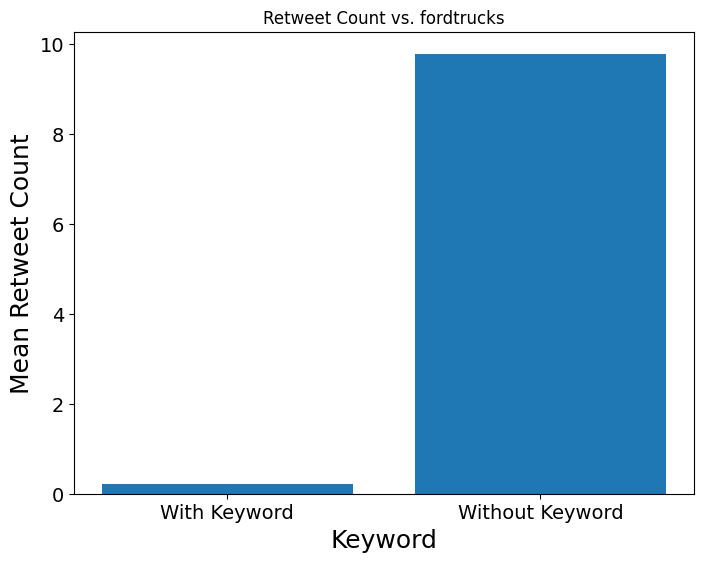

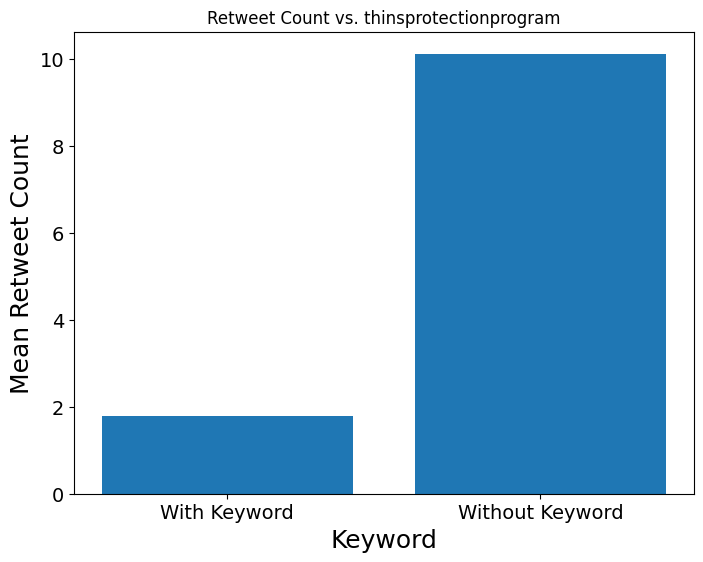

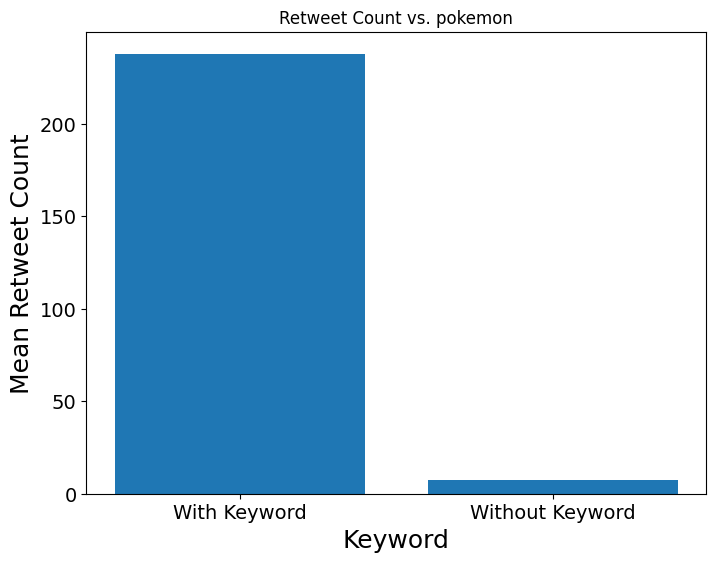

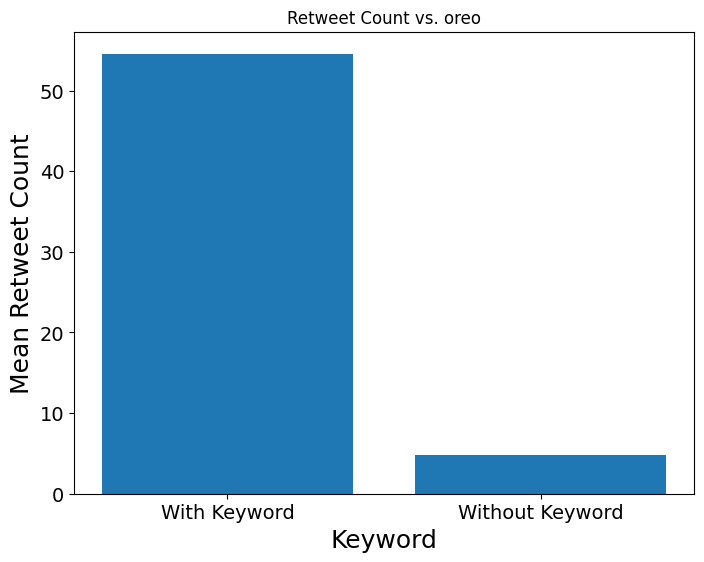

In [ ]:
# prompt: We will look at the keywords "fordtrucks", "thinsprotectionprogram","pokemon", and "oreo". For each keyword, make a bar plot of the mean retweet count of tweets with the word and without the word. Put labels on the axes and a title indicating which keyword you are plotting. A for loop might be useful here

import matplotlib.pyplot as plt
keywords = ["fordtrucks", "thinsprotectionprogram", "pokemon", "oreo"]

for keyword in keywords:
    # Calculate the mean retweet count for tweets with and without the keyword
    with_keyword = df[df.text.str.contains(keyword, case=False, na=False)]['retweet_count'].mean()
    without_keyword = df[~df.text.str.contains(keyword, case=False, na=False)]['retweet_count'].mean()

    # Create a bar plot
    plt.bar(['With Keyword', 'Without Keyword'], [with_keyword, without_keyword])
    plt.xlabel('Keyword')
    plt.ylabel('Mean Retweet Count')
    plt.title(f'Retweet Count vs. {keyword}')
    plt.show()



## 3. (10 points) T-test of retweet count

Do a t-test for the retweet count of tweets with and without the keyword for each keyword.  Print your t-statistics and p-values. A `for` loop might be useful here.

In [ ]:
# prompt: Do a t-test for the retweet count of tweets with and without the keyword for each keyword. Print your t-statistics and p-values. A for loop might be useful here.

for keyword in keywords:
    # Extract the retweet counts for tweets with and without the keyword
    with_keyword = df[df.text.str.contains(keyword, case=False, na=False)]['retweet_count']
    without_keyword = df[~df.text.str.contains(keyword, case=False, na=False)]['retweet_count']

    # Perform a t-test to compare the mean retweet count of the two groups
    t_stat, pval = stats.ttest_ind(with_keyword, without_keyword, equal_var=False)

    # Print the results
    print(f"Keyword: {keyword}")
    print(f"t-statistic: {t_stat:.3f}, p-value: {pval:.3f}")



Keyword: fordtrucks
t-statistic: -4.466, p-value: 0.000
Keyword: thinsprotectionprogram
t-statistic: -3.291, p-value: 0.001
Keyword: pokemon
t-statistic: 1.208, p-value: 0.237
Keyword: oreo
t-statistic: 2.411, p-value: 0.017


## 4. (8 points) T-test of retweet count with Holm-Bonferroni Method

Apply the Holm-Bonferroni method to the calculated p-values.  Print the pvalues and whether the retweet count difference is significant at a 1% level for each keyword.

In [ ]:
# prompt: Apply the Holm-Bonferroni method to the calculated p-values. Print the pvalues and whether the retweet count difference is significant at a 1% level for each keyword.

# Calculate the adjusted p-values using the Holm-Bonferroni method
pvals = [stats.ttest_ind(df[df.text.str.contains(keyword, case=False, na=False)]['retweet_count'],
                          df[~df.text.str.contains(keyword, case=False, na=False)]['retweet_count'],
                          equal_var=False)[1] for keyword in keywords]
adjusted_pvals = multipletests(pvals, method='holm')[1]

# Print the p-values and significance
for i, keyword in enumerate(keywords):
    print(f"Keyword: {keyword}")
    print(f"p-value: {pvals[i]:.3f}")
    print(f"Adjusted p-value: {adjusted_pvals[i]:.3f}")
    if adjusted_pvals[i] < 0.01:
        print("The retweet count difference is significant at a 1% level.")
    else:
        print("The retweet count difference is not significant at a 1% level.")



Keyword: fordtrucks
p-value: 0.000
Adjusted p-value: 0.000
The retweet count difference is significant at a 1% level.
Keyword: thinsprotectionprogram
p-value: 0.001
Adjusted p-value: 0.003
The retweet count difference is significant at a 1% level.
Keyword: pokemon
p-value: 0.237
Adjusted p-value: 0.237
The retweet count difference is not significant at a 1% level.
Keyword: oreo
p-value: 0.017
Adjusted p-value: 0.033
The retweet count difference is not significant at a 1% level.


## 5. (10 points) Oreo vs. Pokemon

Apply a t-test to compare the mean retweet count of tweets that contain `"pokemon"` to those that contain `"oreo"`.  Print the mean retweet count of each group of tweets, the t-statistic and p-value.  Is the difference significant at a 1% level?

In [ ]:
# prompt: Apply a t-test to compare the mean retweet count of tweets that contain "pokemon" to those that contain "oreo". Print the mean retweet count of each group of tweets, the t-statistic and p-value. Is the difference significant at a 1% level?

# Extract the retweet counts for tweets with "pokemon" and "oreo"
pokemon_retweets = df[df.text.str.contains("pokemon", case=False, na=False)]['retweet_count']
oreo_retweets = df[df.text.str.contains("oreo", case=False, na=False)]['retweet_count']

# Calculate the mean retweet count for each group
mean_pokemon = pokemon_retweets.mean()
mean_oreo = oreo_retweets.mean()

# Print the mean retweet counts
print(f"Mean retweet count for tweets with 'pokemon': {mean_pokemon:.3f}")
print(f"Mean retweet count for tweets with 'oreo': {mean_oreo:.3f}")

# Perform a t-test to compare the mean retweet count of the two groups
t_stat, pval = stats.ttest_ind(pokemon_retweets, oreo_retweets, equal_var=False)

# Print the t-statistic and p-value
print(f"t-statistic: {t_stat:.3f}, p-value: {pval:.3f}")

# Check for significance at a 1% level
if pval < 0.01:
    print("The difference in mean retweet count is significant at a 1% level.")
else:
    print("The difference in mean retweet count is not significant at a 1% level.")


Mean retweet count for tweets with 'pokemon': 237.867
Mean retweet count for tweets with 'oreo': 54.563
t-statistic: 0.955, p-value: 0.347
The difference in mean retweet count is not significant at a 1% level.


# Problem 3. (22 points) Comparing Users

## 1. (2 points) Load data

Load the tweets in the file `"data/tweets_KingJamesStephenCurry30.csv"` into a dataframe.  These are tweets for a few prominent Twitter users.  Print out the unique values in the column `screen_name`.

In [ ]:
fname = "data/tweets_KingJamesStephenCurry30.csv"

df_all = pd.read_csv(fname)
ntweets = len(df_all)
print(f"dataframe has {ntweets} tweets")
df_all.screen_name.unique()

dataframe has 2036 tweets


array(['KingJames', 'StephenCurry30'], dtype=object)

## 2. (10 points) Fisher exact test for keyword usage

Do a Fisher exact test to determine if users with screen names `"KingJames"` and `"StephenCurry30"` use the word `"champion"` with the same frequency.  Print the values in your contingency table (`a`,`b`,`c`,`d` defined in lecture).  Print the p-value and  whether the difference significant at a 1% level.

In [ ]:
w0 = 'KingJames'
w1= 'StephenCurry30'
keyword ='champion'  #you can pick any keyword you like, not just the ones in the keywords list

df2 = df_all[df_all.screen_name.isin([w0,w1])]  #df1 only has tweets from the two users you want to compare
contingency_table = pd.crosstab(df2['screen_name'],
                                df2['text'].str.contains(keyword))

print(f"Contingency Table for {keyword}")
contingency_table

Contingency Table for champion


text,False,True
screen_name,,
KingJames,1014,2
StephenCurry30,1006,14


In [ ]:
alpha = 0.01  #significance level

# Perform Fisher exact test
oddsratio, pval = stats.fisher_exact(contingency_table)


print('Fisher exact test')
print(f"{keyword}: odds ratio = {oddsratio:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Fisher exact test
champion: odds ratio = 7.056 (4.045e-03)

Significant at 1% level


## 3. (10 point) Engagement

Define engagement as the ratio of `favorite_count` to `views` count.  Do a t-test to determine if `"KingJames"` and `"StephCurry30"` have the same engagement.  Print the mean engagement of each user, the t-statistic, p-value, and if the difference significant at a 1% level.

In [ ]:
# prompt: Define engagement as the ratio of favorite_count to views count. Do a t-test to determine if "KingJames" and "StephCurry30" have the same engagement. Print the mean engagement of each user, the t-statistic, p-value, and if the difference significant at a 1% level.

df2['engagement'] = df2['favorite_count']/df2['view_count']
df2_James = df2[df2.screen_name=='KingJames']
df2_Curry = df2[df2.screen_name=='StephenCurry30']

engagement_James = df2_James['engagement'].mean()
engagement_Curry = df2_Curry['engagement'].mean()

t_stat, pval = stats.ttest_ind(df2_James['engagement'], df2_Curry['engagement'], equal_var=False)

print(f"Mean engagement for KingJames: {engagement_James:.3f}")
print(f"Mean engagement for StephenCurry30: {engagement_Curry:.3f}")
print(f"t-statistic: {t_stat:.3f}, p-value: {pval:.3e}")

if pval <= 0.01:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")


Mean engagement for KingJames: 0.007
Mean engagement for StephenCurry30: 0.011
t-statistic: nan, p-value: nan
Not significant at 1% level


# Problem 4. (14 points) Tweet Day

We will look at the effect the day of the week has on the retweet count for Lebron James.

## 1. (4 points) Plot retweet count vs day

From the tweets you loaded from the file `"data/tweets_KingJamesStephenCurry30.csv"`, get the tweets of the screen name `"KingJames"`.  Make a bar plot of the mean retweet count vs. day of the week (you can keep the time in UTC).  Make sure to label axes and put the screen name in the title.

<ipython-input-90-ee3bd4557fd8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_James['day'] = pd.to_datetime(df_James['created_at']).dt.day_name()


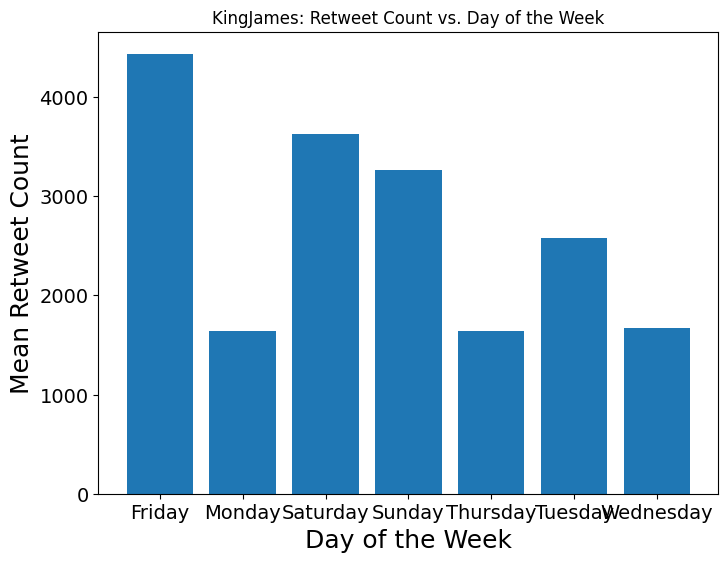

In [ ]:
# prompt: From the tweets you loaded from the file "data/tweets_KingJamesStephenCurry30.csv", get the tweets of the screen name "KingJames". Make a bar plot of the mean retweet count vs. day of the week (you can keep the time in UTC). Make sure to label axes and put the screen name in the title.

import pandas as pd
import matplotlib.pyplot as plt
df_James = df_all[df_all.screen_name == 'KingJames']
df_James['day'] = pd.to_datetime(df_James['created_at']).dt.day_name()
mean_retweets_by_day = df_James.groupby('day')['retweet_count'].mean()

# Create a bar plot
plt.bar(mean_retweets_by_day.index, mean_retweets_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Mean Retweet Count')
plt.title('KingJames: Retweet Count vs. Day of the Week')
plt.show()


## 2. (10 points) T-test of Monday vs. Friday retweet count

Apply a t-test to compare the mean retweet count of tweets posted on Sunday vs. posted on Thursday.  Print the mean retweet count of each group of tweets, the t-statistic and p-value.  Is the difference significant at a 1% level?

In [ ]:
# prompt: Apply a t-test to compare the mean retweet count of tweets posted on Sunday vs. posted on Thursday. Print the mean retweet count of each group of tweets, the t-statistic and p-value. Is the difference significant at a 1% level?

# Extract the retweet counts for tweets posted on Sunday and Thursday
sunday_retweets = df_James[df_James['day'] == 'Sunday']['retweet_count']
thursday_retweets = df_James[df_James['day'] == 'Thursday']['retweet_count']

# Calculate the mean retweet count for each group
mean_sunday = sunday_retweets.mean()
mean_thursday = thursday_retweets.mean()

# Print the mean retweet counts
print(f"Mean retweet count for tweets posted on Sunday: {mean_sunday:.3f}")
print(f"Mean retweet count for tweets posted on Thursday: {mean_thursday:.3f}")

# Perform a t-test to compare the mean retweet count of the two groups
t_stat, pval = stats.ttest_ind(sunday_retweets, thursday_retweets, equal_var=False)

# Print the t-statistic and p-value
print(f"t-statistic: {t_stat:.3f}, p-value: {pval:.3e}")

# Check for significance at a 1% level
if pval < 0.01:
    print("The difference in mean retweet count is significant at a 1% level.")
else:
    print("The difference in mean retweet count is not significant at a 1% level.")


Mean retweet count for tweets posted on Sunday: 3262.431
Mean retweet count for tweets posted on Thursday: 1643.366
t-statistic: 2.332, p-value: 2.056e-02
The difference in mean retweet count is not significant at a 1% level.
